# Notebook to compare Model Results in R17 Maritime, UCLA vs UA 

# Step 0 - Prepare Notebook

In [1]:
import os
import time 
import json
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from snowML.datapipe.utils import data_utils as du
from snowML.LSTM import set_hyperparams as sh
from snowML.LSTM import LSTM_pre_process as pp 
from snowML.LSTM import LSTM_train as LSTM_tr
from snowML.LSTM import LSTM_metrics as met
from snowML.LSTM import LSTM_plot3 as plot3
from snowML.Scripts import local_training_mixed_loss as ml


# Step 1 - Define HyperParams and Test Hucs 

In [2]:
# get list of hucs 
f = "../../src/snowML/datapipe/huc_lists/MandM_hucs_.json"
with open(f, 'r', encoding='utf-8') as file:
    data = json.load(file)
hucs_mar = data["maritime_hucs"]
print(f"Number of hcs_mar is {len(hucs_mar)}")


Number of hcs_mar is 154


In [3]:
# error ls 
error_ls = ['170300010105',
  '171100060102',
  '170200110203',
  '171100060106',
  '170200090107',
  '171100090201',
  '171100060204',
  '171100050803',
  '170200110201', 
  '171100080201',
  '170300020304',
  '171100050603',
  '171100080204',
  '171100060103',
  '170200090204',
  '171100090203',
  '170200090106',
  '171100060302',
  '171100050602']
len(error_ls)

19

In [4]:
error_ls_2 = [ '171100060204',
 '171100090201',
 '170300010105',
 '171100060102',
 '171100050803',
 '170200090106',
 '171100060302',
 '171100060106',
 '171100090203',
 '171100080204',
 '170300020304',
 '171100090502',
 '170200110203',
 '170200090204',
 '171100050904',
 '170300020101',
 '170300020103',
 '170300020301',
 '170200090107',
 '171100060103',
 '171100050603']

In [5]:
hucs_mar_clean = [huc for huc in hucs_mar if huc not in error_ls]
len(hucs_mar_clean)

135

In [6]:
hucs_mar_clean2 = [huc for huc in hucs_mar_clean if huc not in error_ls_2]
len(hucs_mar_clean2)

130

In [7]:
# set hyperparams
# load base line params 
params = sh.create_hyper_dict()
# reset the ones we care about
params["learning_rate"] = .001
params["n_epochs"] = 5   # NOTE ONLY 5 EPOCHS!! 
params["batch_size"] = 32
params["var_list"] = ['mean_pr', 'mean_tair']
params["expirement_name"] = "UA_UCLA_Compare"
params["loss_type"] = "mse"
params["train_size_dimension"] = "time"
params["train_size_fraction"] = .67
params["recursive_rredict"] = False 
params["UCLA"] = False # start w/ UA data then update 
#params

# Step 2 - Define model functions 

In [8]:
def pre_process(huc, params): 
    # normalize the data and create train/test split 
    df_dict = pp.pre_process_separate([huc], params["var_list"], UCLA = params["UCLA"], filter_dates=params["filter_dates"])
    train_size_frac = params["train_size_fraction"]
    df = df_dict[huc]
    df_train, _, _, _ = pp.train_test_split_time(df, train_size_frac)
    return df_dict, df_train

def train_model (df_train, params): 
    model_dawgs, optimizer_dawgs, loss_fn_dawgs = ml.initialize_model(params)
   
    for epoch in range(params["n_epochs"]):
        # for local training, call fine_tune instead of pre_train
        #print(f"Training in epoch {epoch}")
        LSTM_tr.fine_tune(
            model_dawgs,
            optimizer_dawgs,
            loss_fn_dawgs,
            df_train,
            params,
            epoch
            )
    return model_dawgs 

def evaluate(model_dawgs_trained, df_dict, huc, params):
    if params["UCLA"]:
        suffix = "UCLA"
    else: 
        suffix = "UA"
    data, y_tr_pred, y_te_pred, y_tr_true, y_te_true,  y_te_pred_recur, train_size, = LSTM_tr.predict_prep (model_dawgs_trained,
                df_dict, huc, params)
    metric_dict_test = met.calc_metrics(y_te_true, y_te_pred, metric_type = f"test_{suffix}")
    if y_te_pred_recur is not None:
        metric_dict_test_recur = met.calc_metrics(y_te_true, y_te_pred_recur, metric_type = f"test_recur_{suffix}")
        combined_dict = {**metric_dict_test, **metric_dict_test_recur}
    else:
        combined_dict = metric_dict_test
        
    return combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size


def combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size, params):
    results_df = data[["mean_swe"]].copy()
    results_df["y_tr_pred"] = list(y_tr_pred) + [float('nan')] * (len(results_df) - len(y_tr_pred))
    results_df["y_te_pred"] = [float('nan')] * (train_size+params["lookback"]) + list(y_te_pred)
    results_df["y_tr_true"] = list(y_tr_true) + [float('nan')] * (len(results_df) - len(y_tr_true))
    results_df["y_te_true"] = [float('nan')] *(train_size+params["lookback"]) + list(y_te_true)
    return results_df

def label_results(df, suffix):
    df = df.add_suffix(f"_{suffix}")
    return df

def run_one_data_type (huc, params, data_type = "UA"): 
    if data_type == "UCLA": 
        params["UCLA"] = True 
        suffix = "UCLA" 
    else: 
        params["UCLA"] = False
        suffix = "UA"
    df_dict, df_train = pre_process(huc, params)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # ignore warning about drop param being irrelevant with single deep layer
        model_dawgs_trained = train_model(df_train, params)
    combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size = evaluate(model_dawgs_trained, df_dict, huc, params)
    df_results = combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size, params)
    df_results = label_results(df_results, suffix)
    return combined_dict, df_results, tr_size

def run_all(hucs, params, dis = False): 
    #time_start = time.time()
    dict_UA, results_df_UA, tr_size_UA  = run_one_data_type(huc, params)
    dict_UCLA, results_df_UCLA, tr_size_UCLA = run_one_data_type (huc, params, data_type = "UCLA")
    metrics_dict_all = {**dict_UA, **dict_UCLA}
    results_df_all = pd.concat([results_df_UA, results_df_UCLA], axis=1)
    plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size_UA, huc, params, dis = dis)
    #du.elapsed(time_start)
    return metrics_dict_all, results_df_all
       

def plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size, huc, params, dis = False):
    cutoff = tr_size + params["lookback"]
    df_plot = results_df_all.iloc[cutoff:]

    # Prepare data for plots
    plot_dict_UA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UA"], "blue", "SWE Estimates UA Data (Physics Based Model)", n_offset=0)
    plot_dict_UA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UA"], "green", "SWE Predictions UA Data", n_offset=0)

    plot_dict_UCLA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UCLA"], "black", "SWE Estimates UCLA Data (Physics Based Model)", n_offset=0)
    plot_dict_UCLA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UCLA"], "red", "SWE Predictions UCLA Data", n_offset=0)

    x_axis_vals = df_plot.index
    ttl = f"SWE_Actual_vs_Predicted_for_huc_{huc}"

    # Temp file paths
    filenames = [f"plot_{i}.png" for i in range(3)]

    # Plot and save each figure
    plot3.plot3b(x_axis_vals, [plot_dict_UA_true, plot_dict_UA_pred], ttl + "_UA_data", metrics_dict=dict_UA)
    plt.savefig(filenames[0])
    plt.close()

    plot3.plot3b(x_axis_vals, [plot_dict_UCLA_true, plot_dict_UCLA_pred], ttl + "_UCLA_data", metrics_dict=dict_UCLA)
    plt.savefig(filenames[1])
    plt.close()

    plot3.plot3b(x_axis_vals,
                 [plot_dict_UA_true, plot_dict_UA_pred, plot_dict_UCLA_true, plot_dict_UCLA_pred],
                 ttl, metrics_dict=metrics_dict_all)
    plt.savefig(filenames[2])
    plt.close()

    # Combine saved plots vertically
    images = [Image.open(fname) for fname in filenames]
    widths, heights = zip(*(img.size for img in images))

    total_height = sum(heights)
    max_width = max(widths)
    combined_img = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for img in images:
        combined_img.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the final combined image
    output_path = f"charts/SWE_combined_plots_{huc}.png"
    combined_img.save(output_path)
    if dis: 
        display(combined_img)
    
    # Cleanup temporary files
    for fname in filenames:
        os.remove(fname)

    print(f"Saved combined plot to {output_path}")


# Step 3 - Get Results Sample Huc 

In [9]:
huc = 171100050606

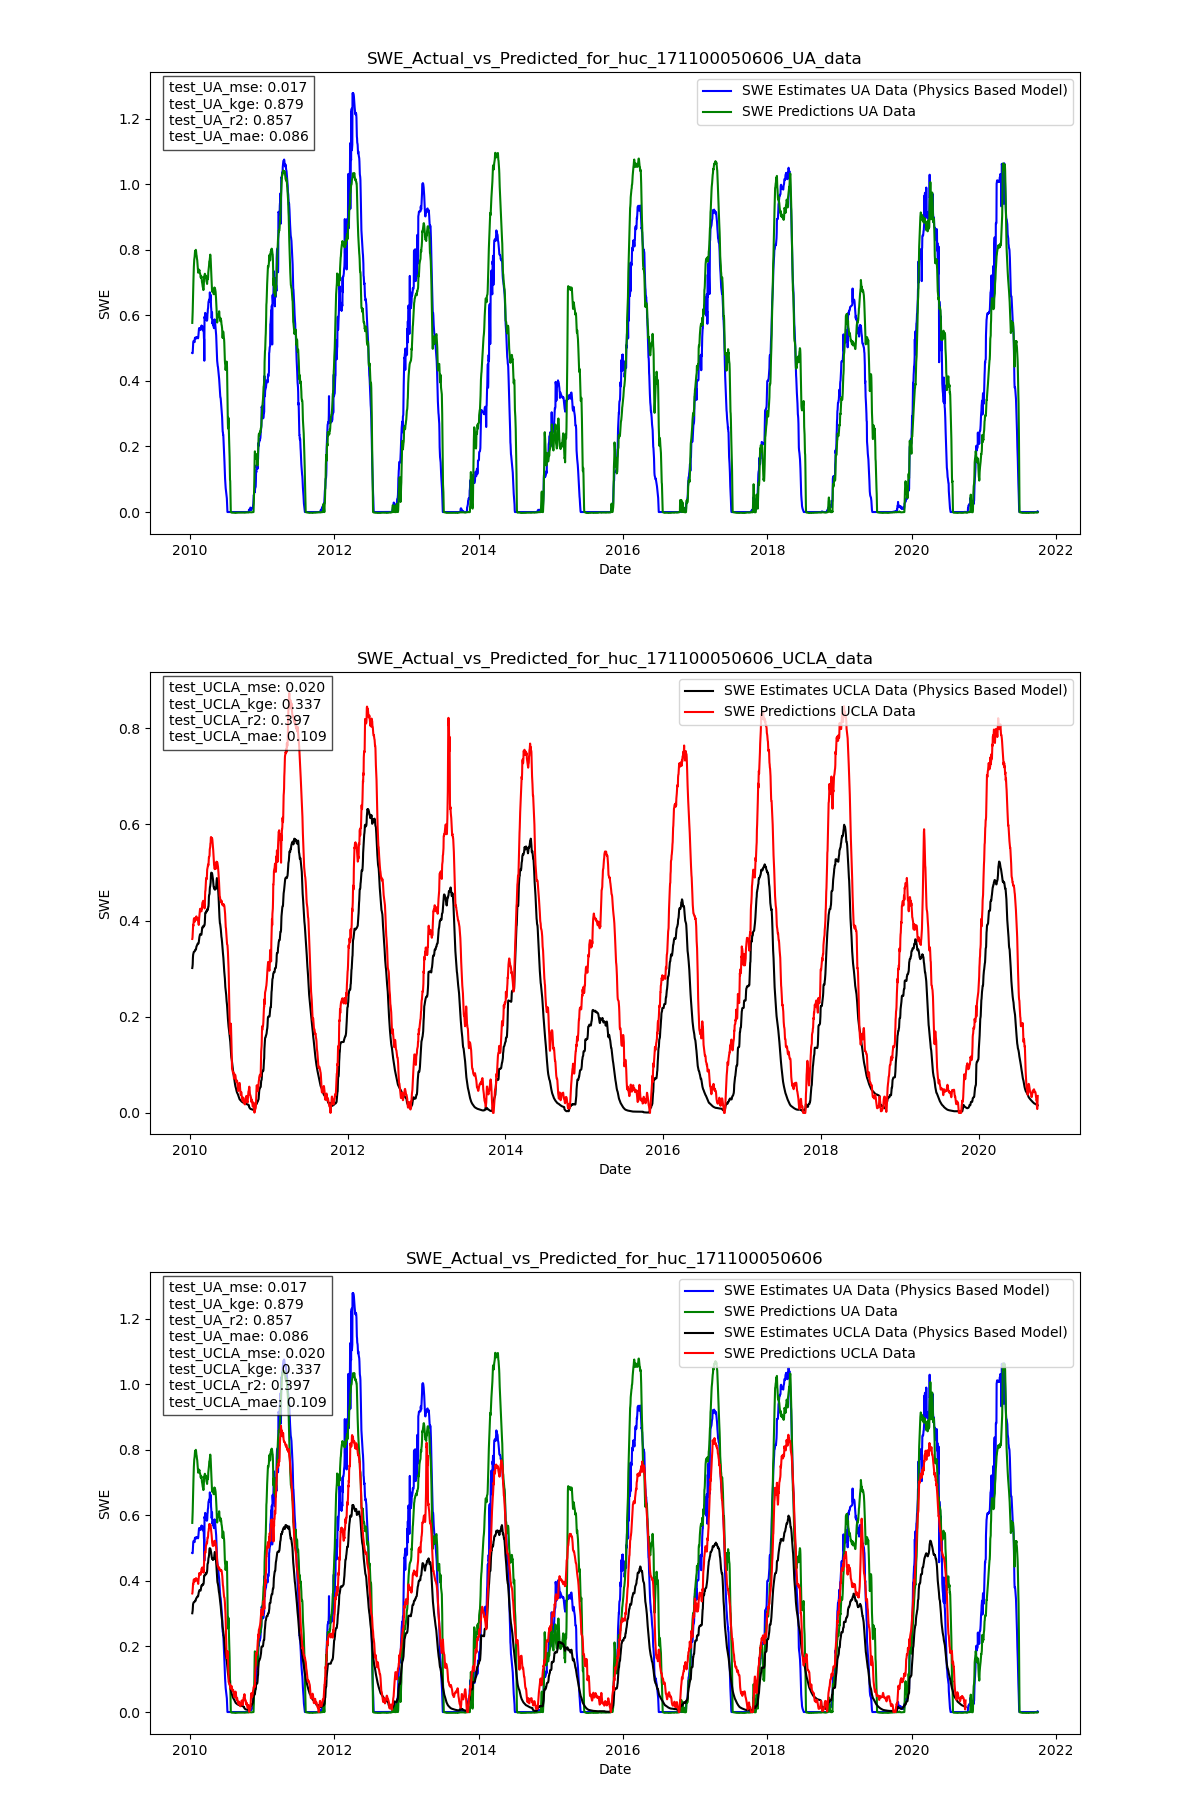

Saved combined plot to charts/SWE_combined_plots_171100050606.png


In [10]:
dict, df = run_all(huc, params, dis = True)

In [11]:
dict

{'test_UA_mse': 0.016999343,
 'test_UA_kge': 0.8794785929903545,
 'test_UA_r2': 0.8571813553333232,
 'test_UA_mae': 0.085788876,
 'test_UCLA_mse': 0.019642826,
 'test_UCLA_kge': 0.3369922765380391,
 'test_UCLA_r2': 0.39672070286553973,
 'test_UCLA_mae': 0.10934801}

In [12]:
df

,mean_swe_UA,y_tr_pred_UA,y_te_pred_UA,y_tr_true_UA,y_te_true_UA,mean_swe_UCLA,y_tr_pred_UCLA,y_te_pred_UCLA,y_tr_true_UCLA,y_te_true_UCLA
day,,,,,,,,,,
1984-10-01,0.000000,[0.74823266],NaN,[0.9314286],NaN,0.000000,[0.47738606],NaN,[0.54418176],NaN
1984-10-02,0.000000,[0.7758884],NaN,[0.565],NaN,0.000000,[0.49726313],NaN,[0.5512264],NaN
1984-10-03,0.000000,[0.7790124],NaN,[0.871],NaN,0.000000,[0.5051596],NaN,[0.5540232],NaN
1984-10-04,0.000000,[0.78303355],NaN,[0.9045714],NaN,0.000000,[0.51314557],NaN,[0.55521774],NaN
1984-10-05,0.000000,[0.79737407],NaN,[0.9431429],NaN,0.000036,[0.52640563],NaN,[0.55822414],NaN
...,...,...,...,...,...,...,...,...,...,...
2021-09-26,0.000000,NaN,[-0.0019363463],NaN,[0.0],NaN,NaN,NaN,NaN,NaN
2021-09-27,0.000000,NaN,[-0.0016909218],NaN,[0.0],NaN,NaN,NaN,NaN,NaN
2021-09-28,0.000000,NaN,[-0.0013297244],NaN,[0.0],NaN,NaN,NaN,NaN,NaN


# Step 4 Look through all the maritime hucs

In [13]:
df_results = None
count = 0

for huc in hucs_mar_clean2:    
    count += 1
    print(f"processing huc {count}")
    dict, df = run_all(huc, params)
    f_out = f"model_results_UA_UCLA_huc_{huc}"
    b = "snowml-results"
    du.dat_to_s3(df, b, f_out, file_type="csv")
    new_row = pd.DataFrame([dict])
    new_row["huc"] = huc
    
    if df_results is None:
        df_results = new_row
    else:
        df_results = pd.concat([df_results, new_row], ignore_index=True)

df_results.set_index("huc", inplace=True)
f_out = "metrics_UA_v_UCLA_maritime"
du.dat_to_s3(df_results, b, f_out, file_type="csv")
df_results


processing huc 1
Saved combined plot to charts/SWE_combined_plots_170200090101.png
File model_results_UA_UCLA_huc_170200090101.csv successfully uploaded to snowml-results
processing huc 2
Saved combined plot to charts/SWE_combined_plots_170200090102.png
File model_results_UA_UCLA_huc_170200090102.csv successfully uploaded to snowml-results
processing huc 3
Saved combined plot to charts/SWE_combined_plots_170200090103.png
File model_results_UA_UCLA_huc_170200090103.csv successfully uploaded to snowml-results
processing huc 4
Saved combined plot to charts/SWE_combined_plots_170200090104.png
File model_results_UA_UCLA_huc_170200090104.csv successfully uploaded to snowml-results
processing huc 5
Saved combined plot to charts/SWE_combined_plots_170200090105.png
File model_results_UA_UCLA_huc_170200090105.csv successfully uploaded to snowml-results
processing huc 6
Saved combined plot to charts/SWE_combined_plots_170200090108.png
File model_results_UA_UCLA_huc_170200090108.csv successfully u

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae
huc,,,,,,,,
170200090101,0.010913,0.953139,0.936301,0.063077,0.012059,0.795374,0.814406,0.077903
170200090102,0.012839,0.958892,0.921510,0.077216,0.019317,0.682433,0.737180,0.107234
170200090103,0.010252,0.860622,0.919722,0.060770,0.005227,0.900711,0.905435,0.048245
170200090104,0.011150,0.945691,0.938038,0.069428,0.009554,0.862539,0.903021,0.080058
170200090105,0.012196,0.874654,0.948062,0.073126,0.035453,0.646565,0.687399,0.158299
...,...,...,...,...,...,...,...,...
170200100202,0.009178,0.927356,0.914486,0.061903,0.010334,0.789447,0.585399,0.070638
170200100203,0.016586,0.833765,0.850510,0.085076,0.009045,0.738561,0.761653,0.064074
171100070101,0.014830,0.417335,0.530286,0.052854,0.033698,0.171635,0.154021,0.135177


In [15]:
df_results.describe()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,0.022688,0.747018,0.775218,0.084485,0.038891,0.519346,0.280997,0.120808
std,0.022931,0.187464,0.156837,0.040323,0.130676,0.295807,1.619039,0.120120
min,0.000382,-0.171078,-0.029956,0.008983,0.000994,-1.191927,-15.635068,0.021404
25%,0.009790,0.655191,0.716288,0.059305,0.009499,0.385509,0.341795,0.069292
50%,0.016563,0.798386,0.818405,0.078410,0.019450,0.551818,0.561604,0.104761
75%,0.028154,0.887281,0.887722,0.102308,0.031790,0.723009,0.739564,0.135418
max,0.157908,0.958892,0.953892,0.259727,1.363524,0.925770,0.906552,1.143277


In [16]:
df_results["kge_diff"] = df_results["test_UA_kge"] - df_results["test_UCLA_kge"]
df_results

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
huc,,,,,,,,,
170200090101,0.010913,0.953139,0.936301,0.063077,0.012059,0.795374,0.814406,0.077903,0.157764
170200090102,0.012839,0.958892,0.921510,0.077216,0.019317,0.682433,0.737180,0.107234,0.276459
170200090103,0.010252,0.860622,0.919722,0.060770,0.005227,0.900711,0.905435,0.048245,-0.040089
170200090104,0.011150,0.945691,0.938038,0.069428,0.009554,0.862539,0.903021,0.080058,0.083153
170200090105,0.012196,0.874654,0.948062,0.073126,0.035453,0.646565,0.687399,0.158299,0.228089
...,...,...,...,...,...,...,...,...,...
170200100202,0.009178,0.927356,0.914486,0.061903,0.010334,0.789447,0.585399,0.070638,0.137909
170200100203,0.016586,0.833765,0.850510,0.085076,0.009045,0.738561,0.761653,0.064074,0.095204
171100070101,0.014830,0.417335,0.530286,0.052854,0.033698,0.171635,0.154021,0.135177,0.245700


In [17]:
df_results.describe()

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,0.022688,0.747018,0.775218,0.084485,0.038891,0.519346,0.280997,0.120808,0.227672
std,0.022931,0.187464,0.156837,0.040323,0.130676,0.295807,1.619039,0.120120,0.317825
min,0.000382,-0.171078,-0.029956,0.008983,0.000994,-1.191927,-15.635068,0.021404,-0.624057
25%,0.009790,0.655191,0.716288,0.059305,0.009499,0.385509,0.341795,0.069292,0.047083
50%,0.016563,0.798386,0.818405,0.078410,0.019450,0.551818,0.561604,0.104761,0.212931
75%,0.028154,0.887281,0.887722,0.102308,0.031790,0.723009,0.739564,0.135418,0.373859
max,0.157908,0.958892,0.953892,0.259727,1.363524,0.925770,0.906552,1.143277,1.865776


In [19]:
df_sorted = df_results.sort_values(by="kge_diff", ascending=False)
df_sorted

,test_UA_mse,test_UA_kge,test_UA_r2,test_UA_mae,test_UCLA_mse,test_UCLA_kge,test_UCLA_r2,test_UCLA_mae,kge_diff
huc,,,,,,,,,
170200110307,0.005586,0.673849,0.806183,0.037583,0.031432,-1.191927,-3.364329,0.116109,1.865776
170200110105,0.004777,0.801985,0.866521,0.032555,0.014863,-0.271405,-0.621237,0.086878,1.073391
170200110305,0.005405,0.840189,0.875554,0.037367,0.018266,-0.107967,-0.355883,0.082185,0.948156
170300010302,0.010935,0.909913,0.834879,0.060300,0.009249,-0.037051,-0.009803,0.065665,0.946964
171100080108,0.003324,0.623147,0.563179,0.028285,0.019824,-0.297974,-0.737300,0.091732,0.921121
...,...,...,...,...,...,...,...,...,...
170300020105,0.034623,0.425713,0.651103,0.112247,0.006178,0.874978,0.822230,0.049576,-0.449265
171100051101,0.009948,-0.171078,-0.029956,0.050667,0.029698,0.300754,-0.066485,0.129274,-0.471832
171100050708,0.021465,0.427856,0.538953,0.085840,0.007781,0.920911,0.845550,0.067237,-0.493055


In [14]:
# with mlflow.start_run():
        #ml.set_ml_server(params)
        # log all the params
        #mlflow.log_params(params)
        # log the hucs & train size fraction
        #mlflow.log_param("hucs", hucs)
        # log the model
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}", pickle_module=cloudpickle)
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}")
            